In [1]:
import os

go_up_n_directories = lambda path, n: os.path.abspath(
    os.path.join(*([os.path.dirname(path)] + [".."] * n))
)
os.chdir(go_up_n_directories(os.getcwd(), 4))  # run once (otherwise restart kernel)

In [2]:
# Python natives
import lightgbm as lgb
import pprint
import json
import os
import numpy as np
from datetime import datetime
import pickle
import time
import re
from utilities import evaluation_utils
from ocpa.algo.predictive_monitoring.obj import Feature_Storage
from ocpa.algo.predictive_monitoring import tabular

In [3]:
prediction_task = "regression"
regression = prediction_task == "regression"
target_name = {
    "regression": "event_remaining_time",
    "classification": "event_ea4",
}
# event_attributes = ["ea2", "ea4", "resource_ce", "resource_multi"]
feature_storage_file = (
    "data/CS/feature_encodings/EFG/efg/raw/CS_split_[C2_P2_P3_O3_eas].fs"
)
model_output_path = "models/CS/baselines/eft"

In [4]:
with open(feature_storage_file, "rb") as bin:
    feature_storage: Feature_Storage = pickle.load(bin)

In [5]:
# flatten EFG with same train/test split
eft_train = tabular.construct_table(
    feature_storage, feature_storage.train_indices + feature_storage.validation_indices
)
eft_test = tabular.construct_table(feature_storage, feature_storage.test_indices)

# rename columns that contain JSON special characters (as they are not supported by LightGBM)
rename_columns = lambda col_name: re.sub("[^A-Za-z0-9_]+", "", str(col_name))
eft_train = eft_train.rename(columns=rename_columns)
eft_test = eft_test.rename(columns=rename_columns)

In [6]:
# import dataset into LightGBM framework
X_train, y_train = (
    eft_train.drop(columns=[target_name[prediction_task]]),
    eft_train.loc[:, target_name[prediction_task]],
)
X_valid, y_valid = (
    eft_test.drop(columns=[target_name[prediction_task]]),
    eft_test.loc[:, target_name[prediction_task]],
)

train_data = lgb.Dataset(
    X_train,
    label=y_train,
)
valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
)

In [7]:
if not regression:
    print(
        eft_train[target_name[prediction_task]]
        .value_counts(normalize=True)
        .sort_index()
    )

In [8]:
params = {
    "num_boost_round": 100,
    "stopping_rounds": 100,
    "num_threads": 4,
}
if regression:
    params |= {"objective": "regression", "metric": ["mse", "mae", "mape", "rmse"]}
else:
    params |= {"objective": "multiclass", "metric": ["multi_logloss"], "num_class": 7}


start_train_time = time.time()
bst = lgb.train(
    params,
    train_data,
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(params["stopping_rounds"])],
)
total_train_time = time.time() - start_train_time

/home/tim/Development/OCPPM/.env/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: stopping_rounds
[LightGBM] [Warning] Unknown parameter: stopping_rounds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 592467, number of used features: 15
[LightGBM] [Warning] Unknown parameter: stopping_rounds
[LightGBM] [Info] Start training from score 0.001122
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.833425	valid_0's l1: 0.728565	valid_0's mape: 0.610963	valid_0's rmse: 0.912921


In [9]:
if regression:
    pred_start_time = time.time()
    y_train_preds = bst.predict(X_train)
    train_pred_time = time.time() - pred_start_time

    pred_start_time = time.time()
    y_valid_preds = bst.predict(X_valid)
    valid_pred_time = time.time() - pred_start_time
else:
    pred_start_time = time.time()
    y_train_preds = np.apply_along_axis(
        evaluation_utils.get_preds_from_probs, axis=1, arr=bst.predict(X_train)
    )
    train_pred_time = time.time() - pred_start_time
    pred_start_time = time.time()
    y_valid_preds = np.apply_along_axis(
        evaluation_utils.get_preds_from_probs, axis=1, arr=bst.predict(X_valid)
    )
    valid_pred_time = time.time() - pred_start_time

In [10]:
eval_train = evaluation_utils.get_evaluation(
    y_train, y_train_preds, regression=regression, time=train_pred_time
)
eval_train["report"]["training_time"] = total_train_time
eval_valid = evaluation_utils.get_evaluation(
    y_valid, y_valid_preds, regression=regression, time=valid_pred_time
)

experiment_settings = {"experiment_settings": params}
evaluation_report = {"Train": eval_train, "Test": eval_valid}

In [11]:
with open(os.path.join(model_output_path, "experiment_settings.json"), "w") as fp:
    json.dump(experiment_settings, fp, indent=2)
with open(os.path.join(model_output_path, "evaluation_report.json"), "w") as fp:
    json.dump(evaluation_report, fp, indent=2)
pprint.pprint(evaluation_report)

{'Test': {'report': {'MAE': 0.7285652486668991,
                     'MAPE': 1.8009737370902474,
                     'MSE': 0.8334248179135839,
                     'R^2': 0.16912865250431852,
                     'prediction_time': 0.16974449157714844}},
 'Train': {'report': {'MAE': 0.7166747234763947,
                      'MAPE': 4.639090765712013,
                      'MSE': 0.8034622388703362,
                      'R^2': 0.1943916009476021,
                      'prediction_time': 0.9934005737304688,
                      'training_time': 15.895859479904175}}}


In [ ]:
import shap

shap_values = shap.TreeExplainer(bst).shap_values(X_valid)

/home/tim/Development/OCPPM/.env/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/tim/Development/OCPPM/.env/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizatio

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


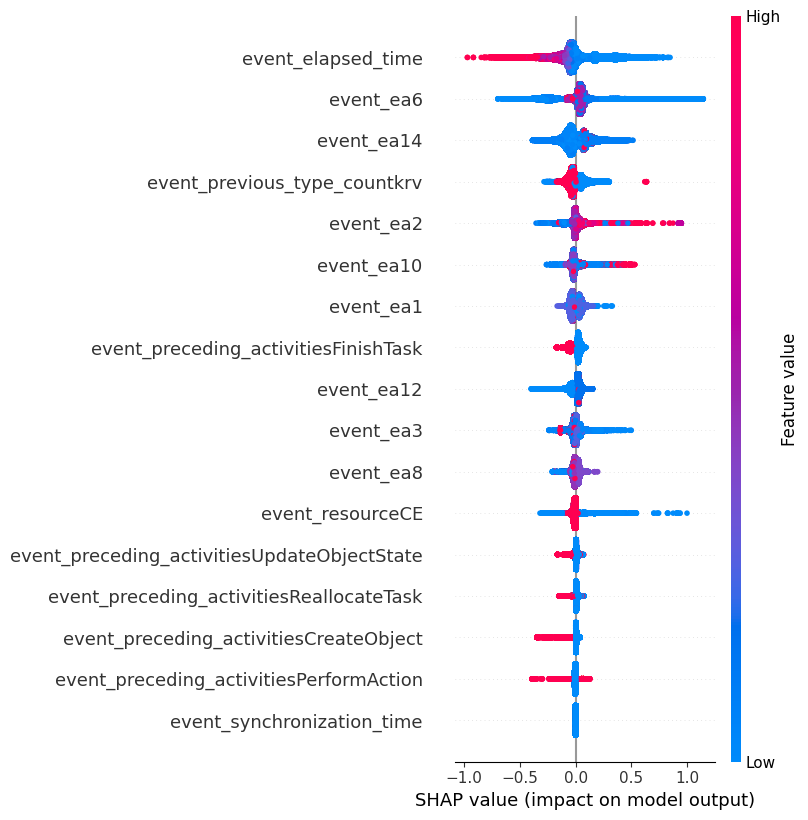

In [ ]:
shap.summary_plot(shap_values, X_valid, max_display=30)

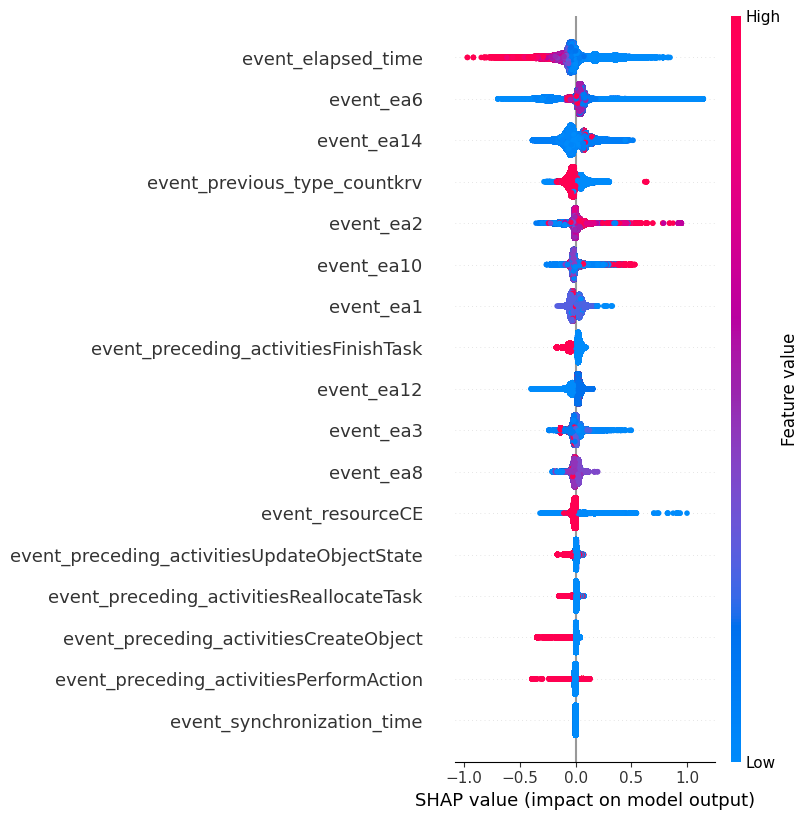

In [ ]:
# OLD
shap.summary_plot(shap_values, X_valid, max_display=30)

In [ ]:
relevant_event_features = [
    "event_elapsed_time",
    "event_ea6",
    "event_ea14",
    "event_ea3",
    "event_previous_type_countkrv",
    "event_ea1",
    "event_ea2",
    "event_ea12",
    "event_ea10",
    "event_ea8",
    "event_resourceCE",
    "event_preceding_activitiesFinishTask",
    "event_preceding_activitiesSaveObject",
    "event_previous_type_countcv",
    "event_resourceMulti",
    "event_preceding_activitiesPerformAction",
    "event_previous_type_countkrs",
]